# K-fold cross-validation test for WA

This notebook will allow the user to perform a K-fold cross validation test on your Watson Assistant workspace 

<div class="alert alert-block alert-info">
<b>Notebook Summary</b>
<br>
      
1. <b>Connect to WA</b> : credentials to connect to the right WA workspace<br>
2. <b>Scan the workspace</b> : download the GTs and intent labels of the entire workspace <br>
3. <b>Test and train split</b> : divide the dataset in test and train sets<br>
4. <b>Create k workspaces</b> : create k workspace and train it with the train-sets<br>
5. <b>Analyse k-fold results</b> : send the test set to the right workspace and analyse the results. <br>
6. <b>Analyse the Report</b> : focus on the performance of each intent.<br>
7. <b>Incorrect Matches</b> : analysis of different types of incorrect matches and possible solutions<br>
8. <b>Highlight Possible `Confused` Intents</b> : highlight possible overlapping intents<br>
</div>



## What is K-fold cross-validation test? 
The K-Fold Cross validation is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. 


In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. 


<img src="images/cross validation 2.png" style="width: 300px;">

In this particular notebook we are going to use the stratified k-fold cross validation. This is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. It is used for unbalanced classes (e.g. intent dimensions that are not equals). 

## What K-fold means in Waston Assistant? 
Using any cross validation method in Watson Assistant will provide a more accurate measure of how well your virtual agent is performing. It is recommended to use the K-fold cross validation every time that we are modifying the workspace with substantial changes (e.g. creation of a new intent etc.)

## Libraries 

In [2]:
#!pip install ibm-watson

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for ibm-watson: filename=ibm_watson-5.2.2-py3-none-any.whl size=403389 sha256=5cdf7fbb47f0050a71e3f30b4e6f930aef08b43a44152b2a9e8614919b3ad4c5
  Stored in directory: c:\users\pet\appdata\local\pip\cache\wheels\34\e8\df\99bea14508f3730b081509ae94a9fb3e876f33aeb465688532
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.10.1-py3-none-any.whl size=61763 sha256=d534d211acbefae3f1da46c7afccd6b7c169011e2bd36e2734b8cf3ac6d8b13b
  Stored in directory: c:\users\pet\appdata\local\pip\cache\wheels\8c\73\32\7569859f9e898aca17b331b0b01ec5979ede178380036f3b0c
Successfully built ibm-watson ibm-cloud-sdk-core


In [1]:
#!pip install msgpack
#!pip install watson-developer-cloud

import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from IPython.display import display
from sklearn.metrics import *
from sklearn.model_selection import *
import itertools

## 1. Connect to Watson Assistant 


<div class="alert alert-block alert-warning">

<b>Data needed from the user</b>
<br>

    
1. <b>Credentials to connect to WA</b> : Log in to IBM cloud, Go to your resource list, select your WA service, and Click Show Credentials - based on what credentials you have, choose option1 (IAM) or option2 (Basic) to connect to your WA instance.<br>
2. <b>Workspace</b> : the ID of the workspace that you want to analyse. - Go to your WA instance, "Skills" tab, click on the three dots of the workspace/skill that you are interested, choose "View API details" and you will find the Workspace ID<br>
3. <b>K-fold number</b>: usually the common used folds number is five. but in can be higher (e.g. 10) or less (i.e. 3) depending on the workspace size.<br>
4. <b>Threshold</b>: this is the minimum level of confidence level that you are expecting in order to check if the input text is triggering the right intent. For example, if the threshold = 0.40 and the input phrase is triggering the correct intent with only 35% of confidence level, we would want to count it as a False Positive (not meeting the required conditions) and not as a True Positive, despite the intent is correct. The default in WA is 0.2. Less than 20% the utterance is classified as `irrelevant`. However, if you need to have a higher threshold it can be set here. 
</div>

1. **IAM token**: With some service instances, you authenticate to the API by using **Identity and Access Management (IAM)** - (IBM Cloud is migrating to token-based IAM authentication). You will need `API Key`, `url` and `version`
2. **Basic Authentication**: In other instances, you authenticate by providing the **username and password** for the service instance. You will need `username`, `password`, `url` and `version`

**Option 1 - IAM Token**

In [2]:
authenticator = IAMAuthenticator('drOJlRcNvS0bqTlCuyDhzpqPMKMB_ANYePZiGtoK_ct_')

assistant = AssistantV1(
    version='2018-07-10',  #USER INPUT
    authenticator=authenticator)

assistant.set_service_url('https://api.eu-de.assistant.watson.cloud.ibm.com/instances/b1ce2268-82ae-445f-837f-ff636308f48a')
    
workspace = '72c72fa9-4b5f-4eb6-b3b4-2fa6308d86ea' #USER INPUT
k_fold_number = 5 #USER INPUT 
threshold = 0.4   #USER INPUT 

**Option 2 - Basic Authentication**

In [2]:
#assistant = AssistantV1(
#    username='',  #USER INPUT
#    password='', #USER INPUT
#    version='2018-07-10',  #USER INPUT
#    url= '') #USER INPUT  
    # e.g. Frankfurt : 'https://gateway-fra.watsonplatform.net/assistant/api'
    # e.g. US-South: 'https://gateway.watsonplatform.net/assistant/api'

#workspace = '' #USER INPUT
#k_fold_number = 5 #USER INPUT 
#threshold = 0.4   #USER INPUT 

### Let's test if everything is working correclty

In [3]:
response = assistant.message(workspace_id=workspace, input={'text': 'Hello!'}, 
                             alternate_intents= True)
dumps = json.dumps(response.get_result(), indent=2)
print(dumps)

data = json.loads(dumps)
intent= data['intents'][0]['intent']
confidence = data['intents'][0]['confidence']
print("intent detected: ", intent, "and the confidence level of the intent is :", confidence)
print('success')

{
  "intents": [
    {
      "intent": "101-Hello",
      "confidence": 1
    },
    {
      "intent": "001.0_Find_Speaker_Fee",
      "confidence": 0
    },
    {
      "intent": "001.1_Speaker_Fee_Search_by_Vendors_Account_Name",
      "confidence": 0
    },
    {
      "intent": "001.2_Speaker_Fee_Search_by_Reference",
      "confidence": 0
    },
    {
      "intent": "001.3_Search_invoice_by_requester",
      "confidence": 0
    },
    {
      "intent": "001.3_Speaker_Fee_Search_by_Assignment",
      "confidence": 0
    },
    {
      "intent": "001.4_Search_Invoice_by_supplier_name",
      "confidence": 0
    },
    {
      "intent": "001.5_Search_Invoice_by_supplier_id",
      "confidence": 0
    },
    {
      "intent": "001_Find_Invoice",
      "confidence": 0
    },
    {
      "intent": "002_Payment_Date",
      "confidence": 0
    }
  ],
  "entities": [],
  "input": {
    "text": "Hello!"
  },
  "output": {
    "generic": [
      {
        "response_type": "text",
        "

## 2. Scan the workspace 
There are two possible ways to do this: 
1. **Option 1** : Download the workspace in Json format and feed the file by using the cell starting with "## FROM JSON FILE" - the file needs to be in 'data' folder in the same directory of the notebook.   
2. **Option 2** : Scan the workspace by usign API calls and creating a dataframe - Use the script starting with "##API CALLS"

### What is the Ground Truth (GT)? 
The complete Ground Truth (GT) which is the collection of all the training sentences of your workspace (of all intents) represents your whole dataset. It's your starting point. 
You should be able to create the dataframe named `df`. 

### Option 1 - from Json file 
You need to download the workspace in Json format. The reading process is faster than option 2. 

In [ ]:
## FROM JSON FILE 

#import json
#from pprint import pprint

#with open('./data/test_erika.json') as f: # USER INPUT - CHANGE THE FILE NAME HERE
#    data = json.load(f)

#def from_json(data):
#    """
#    retrieve the whole workspaces from json 
#    """
#    df2 = pd.DataFrame(columns = ['intent', 'text'])
    
#    for i in range(len(data['intents'])):
#        print("Scanned intent: {}".format(data['intents'][i]['intent']))
#        for j in range(len(data['intents'][i]['examples'])):
#            df2 = df2.append({'intent': data['intents'][i]['intent'],
#                        'text': data['intents'][i]['examples'][j]['text']}
#                       ,ignore_index=True)
#    return df2 

#df = from_json(data)

### Option 2 - using API calls 
The reading process is slower than Option 1 but you can directly create the dataframe `df` without the need to download/upload any file.  

In [4]:
## API CALLS

intents = []
examples = []

def from_API():
    """
    the function will read the workspace via API and create the initial dataframe `df`
    """
    # Call WA to ge the list of the intents 
    response = assistant.list_intents(workspace_id = workspace, )
    obj = json.dumps(response.get_result(), indent=2)
    data = json.loads(obj)
    
    df = pd.DataFrame(columns = ['intent','text'])
    
    for i in range(len(data["intents"])): 
        name_intent = data["intents"][i]["intent"]

        # Call WA to get the list of Examples of each intent 
        response = assistant.list_examples(workspace_id = workspace, intent = name_intent)
        dumps = json.dumps(response.get_result(), indent=2)
        data_examples = json.loads(dumps)

        # get the Groud Truth (examples test) of each intent 
        for j in range(len(data_examples["examples"])): 
            text = data_examples["examples"][j]["text"]
            df = df.append({'intent':name_intent,'text': text},ignore_index=True)
        
        print ("Scanned intent: " , name_intent )
    
    return df 

df = from_API()

Scanned intent:  001.0_Find_Speaker_Fee
Scanned intent:  001.1_Speaker_Fee_Search_by_Vendors_Account_Name
Scanned intent:  001.2_Speaker_Fee_Search_by_Reference
Scanned intent:  001.3_Search_invoice_by_requester
Scanned intent:  001.3_Speaker_Fee_Search_by_Assignment
Scanned intent:  001.4_Search_Invoice_by_supplier_name
Scanned intent:  001.5_Search_Invoice_by_supplier_id
Scanned intent:  001_Find_Invoice
Scanned intent:  002_Payment_Date
Scanned intent:  003_Status_meaning
Scanned intent:  004_Ideal_way_an_invoice_gets_processed
Scanned intent:  005_Non_PO_invoice
Scanned intent:  007_PO_Question
Scanned intent:  008_Data_confirmation_or_Change_of_data
Scanned intent:  009_Payment_Extract
Scanned intent:  010_Expense_report
Scanned intent:  011_Accounting_contact
Scanned intent:  012_Easy_Invoice_problem
Scanned intent:  013_eInvoice
Scanned intent:  014_PDF_Invoices
Scanned intent:  015_Invoice_mail_address
Scanned intent:  016_Approving_an_invoice
Scanned intent:  017_Attaching_a_d

In [5]:
# check how many utterances per intent you have - You should have at least 5 per intent 
df.groupby('intent').count()

,text
intent,
001.0_Find_Speaker_Fee,100
001.1_Speaker_Fee_Search_by_Vendors_Account_Name,21
001.2_Speaker_Fee_Search_by_Reference,10
001.3_Search_invoice_by_requester,27
001.3_Speaker_Fee_Search_by_Assignment,11
...,...
121-Thank..you,23
125-How..old..are..you,10
129-Goodbye,19


## 3. Train and Test Split
We are going to use the [Stratified k-fold split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

The reason is that we want to make sure that each intent dimension is represented correctly in each train sets. 

Each fold needs to contain a test and a train set. The peculiarity of the k-fold is that the test sets will not overlap. Therefore it's important to keep track of each fold because they will be then used to create the k workspace in WA. 

In [6]:
def create_folds(df):
    """
    create the folds for the k-fold test. It is using the Stratifies K-fold division. 
    
    :param df: the dataframe containing the whole GT of the workspace 
    :return folds: a list of folds containing for each fold the train and test set indexes. 
    """
    folds = []
    i = 0
    skf = StratifiedKFold(n_splits = k_fold_number, shuffle = True, random_state = 2)
    for train_index, test_index in skf.split(df['text'], df['intent']):
        fold = {"train": train_index,
                "test": test_index}
        folds.append(fold)
        print("fold num {}: train set: {}, test set: {}".format(i+1,len(folds[i]["train"]), len(folds[i]["test"])))
        i += 1
    
    return folds

## 4. Create k workspaces: 
We want to use the folds generated previously to create the new k workspaces. 
In a `standard` instance of Watson Assistant you should have the default limit of 20 workspaces per instance. 

In [7]:
def count_workspaces():
    """
    counting the existing workspaces and check if there is space for k-workspaces 
    """
    response = assistant.list_workspaces().get_result()
    
    if(len(response['workspaces'])+k_fold_number <=20):
        print("You have space to perform the k-fold test")
    else: 
        remove = len(response['workspaces'])+k_fold_number-20
        print("Be careful! The K-fold test will make you exceed the 20 workspaces limit.")
        print("Make sure to remove {} workspaces before creating the k-fold workspaces".format(remove))
    return 

count_workspaces()

Be careful! The K-fold test will make you exceed the 20 workspaces limit.
Make sure to remove 27 workspaces before creating the k-fold workspaces


In order to limit the amount of API calls during this process we would like to create all the intents and utterances in the same moment that we are creating the workspace. 

### Note : For NON-ENGLISH Workspaces
Make sure to change the language of the workspace `language = 'xx'` in __create_workspace__ function. 

In [8]:
def create_intents(train_index):
    """
    It collects the intents in json format to send when creating the workspace 
        
    :param train_index: that are the results of the 'create_folds' function
    :return intent_results: if a list of dictionaries that will be sent when new workspace will be created
    """
    
    intent_results = []
    for i in train_index:
        row = {}
        text = df.iloc[i]['text']
        intent = df.iloc[i]['intent']

        if not any(d['intent'] == intent for d in intent_results):
            row = { 'intent': intent, 
                    'examples': [ {'text': text } ] } 
        else:
            row = [d for d in intent_results if d.get('intent') == intent][0]
            intent_results[:] = [d for d in intent_results if d.get('intent') != intent]
            e = {'text': text}
            row['examples'].append(e)

        intent_results.append(row)
    
    return intent_results




def create_workspace(intents_json, fold_number):
    """
    create one workspace 
    
    :param intent_json : output of the 'create_intents' function
    :param fold_number: the number of the fold  
    :return workspace_id: the id of the workspace that has been generated
    """
    response = assistant.create_workspace(
        name='K_FOLD test {}'.format(fold_number+1),
        language = 'zh-cn',   # CHANGE LANGUAGE HERE (Default is 'en')
        description='workspace created for k-fold testing', 
        intents = intents_json
    ).get_result()
    
    workspace_id = response.get('workspace_id')
    
    return workspace_id




def create_kfold_WA(folds):
    """
    create the k-fold workspaces in WA
    
    :param folds: are the folds created in the function `create_folds`
    :return workspaces: is a list of workspaces ID generated 
    """
    workspaces = []
    for i in range(len(folds)):
        print("creating K-FOLD workspace {} out of {}".format(i+1, len(folds)))
        train = folds[i]["train"]
        intents = create_intents(train)
        workspace_id = create_workspace(intents, i)
        workspaces.append(workspace_id)
    
    return workspaces

folds = create_folds(df)
workspaces = create_kfold_WA(folds)

fold num 1: train set: 1506, test set: 377
fold num 2: train set: 1506, test set: 377
fold num 3: train set: 1506, test set: 377
fold num 4: train set: 1507, test set: 376
fold num 5: train set: 1507, test set: 376
creating K-FOLD workspace 1 out of 5
creating K-FOLD workspace 2 out of 5
creating K-FOLD workspace 3 out of 5
creating K-FOLD workspace 4 out of 5
creating K-FOLD workspace 5 out of 5


### Check the status 
Before performing any test, we need to make sure that the workspaces have finished training. You can check the status using the cell below. 

In [10]:
def check_status(workspaces): 
    """
    check the status of the workspace just created - You can start the k-fold only when 
    the workspaces are `Available` and not in Training mode. 
    """
    for i in range(len(workspaces)):
        response = assistant.get_workspace(workspace_id = workspaces[i]).get_result()
        status = response['status']
        print("Fold number:{} ({}), Workspace is {}".format(i+1,workspaces[i], status))
        # The status can be: unavailable, training, non-existent, failed 
        if (status != 'Available'):
            print("The workspace is not available - check the details")
    return 

check_status(workspaces)

Fold number:1 (a14625c2-a5bc-4bc2-84eb-5e57d684dced), Workspace is Available
Fold number:2 (1008e2fd-e598-45e4-a9b1-baf94e552a6a), Workspace is Available
Fold number:3 (2cc9b589-2a18-4d6f-a003-0956f5c96a83), Workspace is Available
Fold number:4 (ede3a4f7-9612-406d-8add-f84e6e3e44a4), Workspace is Available
Fold number:5 (d26167e2-2dbf-44e0-ad2e-8c4ace73414c), Workspace is Available


In [11]:
def test_kfold(df_test, ws_id):
    """
    This function will take the regression test uploaded in csv and will send each phrase to WA and collect 
    information on how the system responded. 
    
    :param df_test: the dataframe containing the testing phrases 
    :param ws-id: the index of the fold that would be used to call the correct workspace id that needs to be test 
    :return results: a pandas dataframe with original text, predicted intent and also the results from WA
    """
    results = pd.DataFrame([],columns = ['original_text','predicted_intent','actual_intent1',
                           'actual_confidence1','actual_intent2','actual_confidence2','actual_intent3',
                           'actual_confidence3'])

    for i in range(len(df_test)):

        text = df_test['text'][i]

        response = assistant.message(workspace_id=workspaces[ws_id], input={'text': text}, alternate_intents= True)
        dumps = json.dumps(response.get_result(), indent=2)
        if i != 0:
            print('.',end='')
            if i % 10 == 0: 
                print(i)

        data = json.loads(dumps)

        intent1= data['intents'][0]['intent']
        intent2= data['intents'][1]['intent']
        intent3= data['intents'][2]['intent']
        confidence1 = data['intents'][0]['confidence']
        confidence2 = data['intents'][1]['confidence']
        confidence3 = data['intents'][2]['confidence']

        results = results.append({
                'original_text': df_test["text"][i],
                'predicted_intent': df_test["intent"][i],
                'actual_intent1': intent1, 
                'actual_confidence1':confidence1, 
                'actual_intent2':intent2, 
                'actual_confidence2': confidence2, 
                'actual_intent3': intent3,
                'actual_confidence3': confidence3, 
            }, ignore_index=True)
        
    results.to_csv("./results/kfold_{}_raw.csv".format(ws_id+1), encoding='utf-8')
    
    return results



def run_kfold_test(folds):
    """
    run the k-fold test. It is going to take folds as input and it will send the test dataframes to the right
    workspaces. 
    
    :param folds: output list from the function `create_folds`
    :return test_results: is list of results (dataframes) for each fold.  
    """
    test_results = []
    for i in range(len(folds)):
        print("\n")
        print("RUNNING K-FOLD FOR FOLD NUMBER {}".format(i+1))
        test_index = folds[i]['test']
        df_test = df.iloc[test_index]
        df_test_reindexed = df_test.reset_index()
        results = test_kfold(df_test_reindexed, i)
        test_results.append(results)
    print("\n")
    print("FINISHED")
        
    return test_results

results_kfold = run_kfold_test(folds)



RUNNING K-FOLD FOR FOLD NUMBER 1
..........10
..........20
..........30
..........40
..........50
..........60
..........70
..........80
..........90
..........100
..........110
..........120
..........130
..........140
..........150
..........160
..........170
..........180
..........190
..........200
..........210
..........220
..........230
..........240
..........250
..........260
..........270
..........280
..........290
..........300
..........310
..........320
..........330
..........340
..........350
..........360
..........370
......

RUNNING K-FOLD FOR FOLD NUMBER 2
..........10
..........20
..........30
..........40
..........50
..........60
..........70
..........80
..........90
..........100
..........110
..........120
..........130
..........140
..........150
..........160
..........170
..........180
..........190
..........200
..........210
..........220
..........230
..........240
..........250
..........260
..........270
..........280
..........290
..........300
....

--------------

## 5. Analyse the results 
Once we have the results for each fold, it's time to analyse the results. Let's prepare the data. 



In [12]:
def data_prep(dataframe):
    """
    this function prepares the dataframe. We are adding a new column called "actual_intent_correct" 
    if the intent1 is triggered with less than x% of confidence level (determined in `threshold`) then 
    the value will be put to zero.
    
    :param dataframe: it is the dataframe to wrangle 
    """
    
    dataframe["actual_intent_correct"] = dataframe["actual_intent1"]
    dataframe["actual_intent_correct"] = np.where((dataframe["actual_confidence1"]<threshold),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent1"])
    return dataframe

### Collection of Metrics

      
1. **Accuracy** : In multilabel classification, this function computes subset accuracy, the set of labels predicted for a sample must exactly match the corresponding set of labels in _y_true_.
2. **Precision** : The precision is the ratio _tp / (tp + fp)_ where tp is the number of _true positives_ and fp the number of _false positives_. The precision is intuitively the ability of the classifier not to label as positive a sample that is actually negative.
3. **Recall** : The recall is the ratio _tp / (tp + fn)_ where tp is the number of _true positives_ and fn the number of _false negatives_. The recall is intuitively the ability of the classifier to find all positive samples. 
4. **F-score** : The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The F-beta score weighs recall more than precision by a factor of beta. A value of beta == 1.0 means recall and precision are equally important.

[precision_recall_fscore_support function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)


In [13]:
import warnings
warnings.filterwarnings('ignore')

def define_metrics(results_kfold):
    """
    define the metrics of the k-fold
    
    :param results_kfold: is the list of results coming from `run_kfold_test` function
    :return result_table: is the dataframe containing the metrics for each fold. 
    """
    result_table = pd.DataFrame([],columns=["fold","total_tested","incorrect","accuracy", "precision","recall","fscore"])

    for i in range(len(results_kfold)):
        data = data_prep(results_kfold[i])
        incorrect_n = data.loc[data['actual_intent_correct']!=data["predicted_intent"]]
        incorrect_avg_conf = incorrect_n['actual_confidence1'].mean()
        precision,recall,fscore,support=precision_recall_fscore_support(data["actual_intent_correct"],data["predicted_intent"],average='weighted')
        accuracy = accuracy_score(data["actual_intent_correct"], data["predicted_intent"])
        result_table = result_table.append({
            "fold": i+1,
            "total_tested": len(results_kfold[i]),
            "incorrect": len(incorrect_n),
            "incorrect_avg_confidence": incorrect_avg_conf,
            "accuracy": accuracy, 
            "precision": precision, 
            "recall": recall, 
            "fscore": fscore
        }, ignore_index=True)
    
    return result_table

result_table = define_metrics(results_kfold)
result_table

,fold,total_tested,incorrect,accuracy,precision,recall,fscore,incorrect_avg_confidence
0,1.0,377.0,73.0,0.806366,0.770686,0.806366,0.779922,0.502901
1,2.0,377.0,75.0,0.801061,0.787061,0.801061,0.785934,0.509492
2,3.0,377.0,69.0,0.816976,0.796506,0.816976,0.797746,0.540785
3,4.0,376.0,66.0,0.824468,0.799465,0.824468,0.799919,0.508633
4,5.0,376.0,75.0,0.800532,0.775454,0.800532,0.781506,0.522421


<img src="images/precision-recall-relevant-selected.jpg" style="width: 500px;">

Confusion matrix for the Intent matching


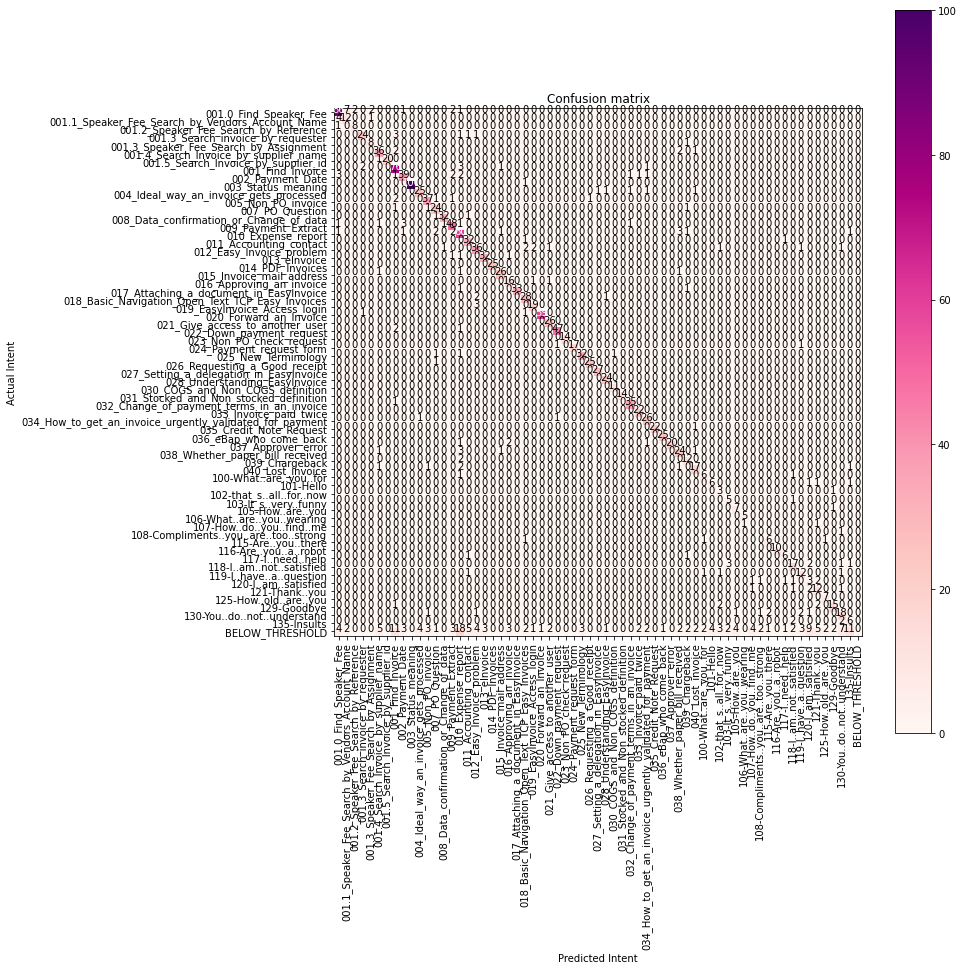

In [14]:
def data_prep_confusion_matrix(list_df):
    """
    this function prepares the dataframe to be then used for the confusion matrix 
    
    :param list_df: is the list of dataframes (results) coming from each fold. 
    :return matrix: it is the confusion matrix that will be displayed in `plot_confusion_matrix`
    :return lab: the lables that are used for the visualisation 
    """
    df = pd.concat(list_df) 
    dataframe = df.reset_index()
    
    dataframe["actual_intent_correct"] = dataframe["actual_intent1"]
    dataframe["actual_intent_correct"] = np.where((dataframe["actual_confidence1"]<threshold),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent1"])
    matrix = confusion_matrix(dataframe["actual_intent_correct"], dataframe["predicted_intent"])
    
    lab1 = dataframe["actual_intent_correct"].unique()
    lab2 = dataframe["predicted_intent"].unique()
    lab = np.union1d(lab1,lab2)
    
    return matrix, lab, dataframe

matrix, lab, combined_df  = data_prep_confusion_matrix(results_kfold)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for the Intent matching")
    else:
        print('Confusion matrix for the Intent matching')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Intent')
    plt.xlabel('Predicted Intent')
    plt.tight_layout()
    
    return 
    
plt.figure(figsize=(14,14))
plot_confusion_matrix(matrix, classes=lab,
                      title='Confusion matrix')

In [15]:
print("OVERALL RESULTS")
accuracy = accuracy_score(combined_df["actual_intent_correct"], combined_df["predicted_intent"])
print("Accuracy:", accuracy)
precision,recall,fscore,support=precision_recall_fscore_support(combined_df["actual_intent_correct"],
                                                                combined_df["predicted_intent"],
                                                                average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("FScore:", fscore)

print("\n")
print("PER INENT - DETAILED RESULTS")
print(classification_report(combined_df["actual_intent_correct"], combined_df["predicted_intent"]))
report = classification_report(combined_df["actual_intent_correct"], combined_df["predicted_intent"])


OVERALL RESULTS
Accuracy: 0.8098778544875199
Precision: 0.764108283496838
Recall: 0.8098778544875199
FScore: 0.7834749915228492


PER INENT - DETAILED RESULTS
                                                          precision    recall  f1-score   support

                                  001.0_Find_Speaker_Fee       0.86      0.85      0.86       101
        001.1_Speaker_Fee_Search_by_Vendors_Account_Name       0.57      0.71      0.63        17
                   001.2_Speaker_Fee_Search_by_Reference       0.80      0.89      0.84         9
                       001.3_Search_invoice_by_requester       0.89      0.80      0.84        30
                  001.3_Speaker_Fee_Search_by_Assignment       0.73      0.89      0.80         9
                   001.4_Search_Invoice_by_supplier_name       0.78      0.88      0.83        41
                     001.5_Search_Invoice_by_supplier_id       1.00      0.95      0.98        21
                                        001_Find_Invoice

## 6. Analysis of the Report 
1. Let's export the analysis above into a CSV - "classification_report.csv" 
2. Let's see what are the least/top performing intents 



In [16]:
import re

def classification_report_csv(report):
    """
    Function that allows to export the report shown above into CSV - The row "BELOW THRESHOLD" 
    was deteled since it's not meaningful in this context. 
    
    return: dataframe_new and the csv is saved in the folder "results"
    """
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        if re.match('.*BELOW_THRESHOLD.*', line):
            break
        row = {}
        row_data = line.split('      ')
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe_new = dataframe[dataframe["class"] != " BELOW_THRESHOLD"]
    #print(dataframe_new)
    dataframe_new.to_csv('./results/classification_report.csv', index = False)
    
    return dataframe_new
    
report_df = classification_report_csv(report)

report_least = report_df.sort_values(by = ['f1_score']).reset_index(drop=True)
report_top = report_df.sort_values(by = ['f1_score'], ascending=False).reset_index(drop=True)



Text(0.5, 1.0, '5 Top Performing intents (F1_score)')

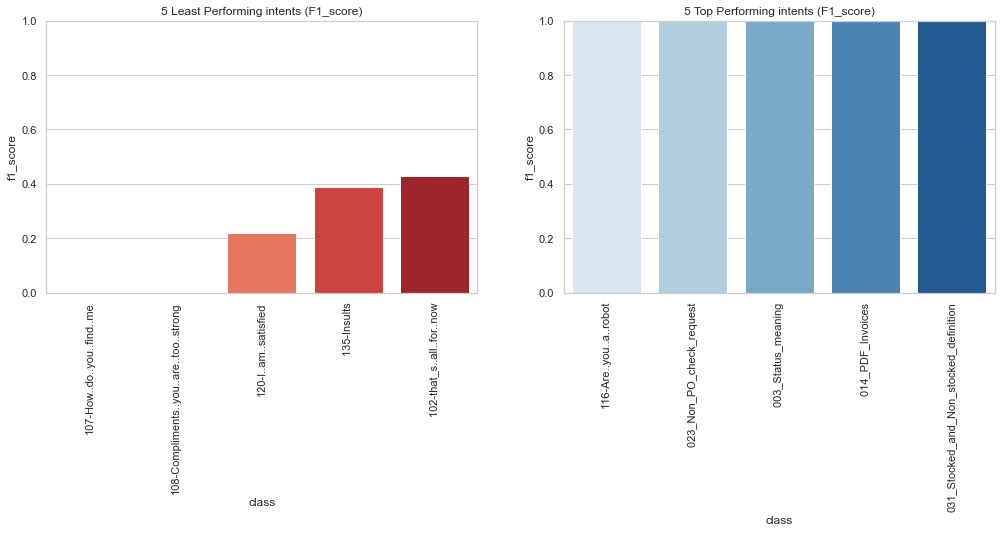

In [17]:
# Visualization of top intents 
import seaborn as sns
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(ncols=2 ,figsize=(17,5))
ax1.set(ylim=(0, 1))
ax2.set(ylim=(0, 1))

# worst performing intents 
sns.barplot(x="class", y="f1_score", data=report_least[:5], palette="Reds", ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("5 Least Performing intents (F1_score)")

# top performing intents
sns.barplot(x="class", y="f1_score", data=report_top[:5], palette="Blues", ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("5 Top Performing intents (F1_score)")


----------------------------------
## 7. Analyse the Incorrect matches
We have identified 3 types of different incorrect matches. 
1. **Incorrect intent was triggered with high confidence**: It is important to understand why the incorrect intent is sensitive to the testing phrase – an N-gram test can be helpful in such cases. This type of error has the priority, since it can have a bad influence on the chatbot’s performance.
2. **Incorrect intent was triggered with low confidence** : Since those intents were triggered with low confidence, this error has less priority compared to problem (1). However, an incorrect intent was still detected. – an N-gram test can be helpful in such cases. Further, more training is necessary in order to boost the confidence level of the correct intent and resolving the conflicts between both intents.
3. **Correct intent but with low confidence** : More training is needed in order to increase the confidence level of the correct intent.

### 7.1. Incorrect intent was triggered with high confidence 

In [18]:
incorrect1 = combined_df.loc[(combined_df["predicted_intent"]!=combined_df["actual_intent1"])&(combined_df["actual_confidence1"]>=threshold)]
if (len(incorrect1) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect1)))
    incorrect1.to_csv('./results/01.wrong_intent_high_confidence.csv', index = False)
    print("File saved in 'results' - 01.wrong_intent_high_confidence.csv")
    

Detected: 204 samples
File saved in 'results' - 01.wrong_intent_high_confidence.csv


### 7.2. Incorrect intent was triggered with low confidence 

In [19]:
incorrect2 = combined_df.loc[(combined_df["predicted_intent"]!=combined_df["actual_intent1"])&(combined_df["actual_confidence1"]<threshold)]
if (len(incorrect2) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect2)))
    incorrect2.to_csv('./results/02.wrong_intent_low_confidence.csv', index = False)
    print("File saved in 'results' - 02.wrong_intent_low_confidence.csv")

Detected: 98 samples
File saved in 'results' - 02.wrong_intent_low_confidence.csv


### 7.3. Correct intent was triggered but with low confidence 

In [20]:
incorrect3 = combined_df.loc[(combined_df["predicted_intent"]==combined_df["actual_intent1"])&(combined_df["actual_confidence1"]<threshold)]
if (len(incorrect3) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect3)))
    incorrect3.to_csv('./results/03.correct_intent_low_confidence.csv', index = False)
    print("File saved in 'results' - 03.correct_intent_low_confidence.csv")

Detected: 56 samples
File saved in 'results' - 03.correct_intent_low_confidence.csv


## 8. Highlight possible Confused Intents
There are different ways to detect if intents are overlapping creating 'confusion' in the bot. This time we will use a pragmatic way: let's check the difference in confidence level between the first and second intent and see if it's less than a certain level (`threshold_confusion` e.g. 10%, 15%). If it is less, then maybe it's a good idea to investigate why the confidence levels are so close to each other and improve the Ground Truth of these intents. 

The first intent needs to be higher than the threshold determined at the beginning of this notebook (`threshold`).  

In [21]:
threshold_confusion = 0.10   ## USER CHOICE

In [22]:
confusion1 = combined_df.loc[(combined_df["actual_confidence1"]-combined_df["actual_confidence2"]<threshold_confusion)&(combined_df["actual_confidence1"]>threshold)]
if (len(confusion1) == 0 ): 
    print ("No overlapping intents found")
else: 
    print("Detected: {} samples".format(len(confusion1)))
    confusion1.to_csv('./results/04.intent_overlap.csv', index = False)
    print("File saved in 'results' - 04.intent_overlap.csv")
    print("\n")
    print("Show unique pairings")
    df = confusion1[['actual_intent1', 'actual_intent2']]
    print(df.groupby(['actual_intent1', 'actual_intent2']).size())
    #print (df)

Detected: 108 samples
File saved in 'results' - 04.intent_overlap.csv


Show unique pairings
actual_intent1                actual_intent2                                  
001.0_Find_Speaker_Fee        001.1_Speaker_Fee_Search_by_Vendors_Account_Name    1
                              001_Find_Invoice                                    1
                              002_Payment_Date                                    1
                              009_Payment_Extract                                 1
                              121-Thank..you                                      1
                                                                                 ..
129-Goodbye                   121-Thank..you                                      1
                              130-You..do..not..understand                        1
130-You..do..not..understand  005_Non_PO_invoice                                  1
                              012_Easy_Invoice_problem                  

### Delete the workspace 
Once you have finished your testing and you have the results, you can delete the workspaces. 

In [23]:
def delete_kfold_workspaces(workspaces):
    """
    delete the workspaces when you dont need them anymore
    """
    for i in range(len(workspaces)):
        print("deleting workspace {} out of {}: {}".format(i+1, len(workspaces), workspaces[i]))
        response = assistant.delete_workspace(
                workspace_id = workspaces[i]).get_result()
    return 

delete_kfold_workspaces(workspaces)

deleting workspace 1 out of 5: a14625c2-a5bc-4bc2-84eb-5e57d684dced
deleting workspace 2 out of 5: 1008e2fd-e598-45e4-a9b1-baf94e552a6a
deleting workspace 3 out of 5: 2cc9b589-2a18-4d6f-a003-0956f5c96a83
deleting workspace 4 out of 5: ede3a4f7-9612-406d-8add-f84e6e3e44a4
deleting workspace 5 out of 5: d26167e2-2dbf-44e0-ad2e-8c4ace73414c


## Improvement List



1. export to CSV - what and which table? 
2. pie / donut chart to show which intents are the overlapping the most. 

## Useful Links 
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

### Author: 
- **[Erika Agostinelli](https://www.linkedin.com/in/erikaagostinelli/)** is a Data Scientist and AI specialist part of IBM Data Science Elite Team where she specializes in Analytics platforms and Machine Learning solutions.

Copyright 2019 IBM Corp. All Rights Reserved.